In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import skimage.transform
import skimage.io
from sklearn.cluster import KMeans
import scipy.misc
import PIL
from PIL import Image, ImageFont, ImageDraw

import numpy as np

from multiprocessing import Pool
import time
import random
import warnings

In [2]:
def try_composite(a, d, n, s):
    # test the base a to see whether it is a witness for the compositeness of n
    if pow(a, d, n) == 1:
        return False
    for i in range(s):
        if pow(a, 2**i * d, n) == n-1:
            return False
    return True # n is definitely composite

    
def is_probable_prime(n, mrpt_num_trials = 5):
    """
    Miller-Rabin primality test.
 
    A return value of False means n is certainly not prime. A return value of
    True means n is very likely a prime.

    """
    assert n >= 2
    # special case 2
    if n == 2:
        return True
    # ensure n is odd
    if n % 2 == 0:
        return False
    # write n-1 as 2**s * d
    # repeatedly try to divide n-1 by 2
    s = 0
    d = n-1
    while True:
        quotient, remainder = divmod(d, 2)
        if remainder == 1:
            break
        s += 1
        d = quotient
    assert(2**s * d == n-1)
                                     
    for i in range(mrpt_num_trials):
        a = random.randrange(2, n)
        if try_composite(a, d, n, s):
            return False
        
    return True # no base tested showed n as composite

assert is_probable_prime(2)
assert is_probable_prime(3)
assert not is_probable_prime(4)
assert  is_probable_prime(5)
assert not is_probable_prime(123456789)
primes_under_1000 = [i for i in range(2, 1000) if is_probable_prime(i)]
assert len(primes_under_1000) == 168
assert primes_under_1000[-10:] == [937, 941, 947, 953, 967, 971, 977, 983, 991, 997]
assert is_probable_prime(643808006803554439230129854961492699151386107534013432918073439524138264842370630061369715394739134090922937332590384720397133335969549256322620979036686633213903952966175107096769180017646161851573147596390153)
assert not is_probable_prime(743808006803554439230129854961492699151386107534013432918073439524138264842370630061369715394739134090922937332590384720397133335969549256322620979036686633213903952966175107096769180017646161851573147596390153)


In [3]:
def get_k_means(image):
    pointcloud = np.reshape(image, (-1, 3))
    kmeans = KMeans(n_clusters=10).fit(pointcloud)
    return kmeans

def create_numbered_image(image, kmeans):
    """
    Turns an RGB image into an image with the labels of clusters of the supplied kmeans classifier. 
    """
    # apply noise
    stdev = np.std(image)
    random_noise = np.random.random_sample(size=image.shape)*(stdev/3)
    image = image + random_noise
    
    orig_shape = image.shape
    image = np.reshape(image, (-1, 3))

    numbered_image = kmeans.predict(image)
    numbered_image = np.reshape(numbered_image, orig_shape[:2])
    
    # make sure the end is uneven
    if numbered_image[-1,-1]%2==0:
        numbered_image[-1,-1] += 1

    return numbered_image

def numbered_image_to_normal_image(numbered_image, kmeans):
    """
    Turns an image with only values between 0 and 9 into a colored image by using the cluster centers 
    of the supplied kmeans classifier. 
    """
    shape = (numbered_image.shape[0], numbered_image.shape[1], 3)
    image = np.zeros(shape)
    for label, color in zip(range(10), kmeans.cluster_centers_):
        image[numbered_image==label] = color
    return image


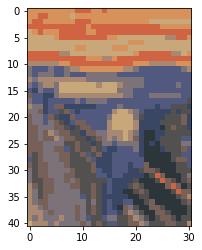

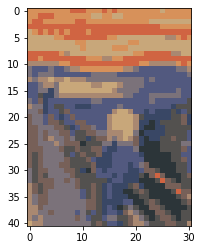

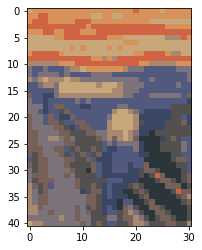

In [4]:
def load_and_resize_image(filename, resize_factor=18):
    image = skimage.io.imread(filename)
    image = image.astype(np.float64)
    image = image / 255.
    
    oldshape = image.shape
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        resized_image = skimage.transform.resize(image, (oldshape[0]//resize_factor, oldshape[1]//resize_factor))

    return resized_image

resized_image = load_and_resize_image('input_pictures/scream.jpg')
kmeans = get_k_means(resized_image)
for _ in range(3):
    n_image = create_numbered_image(resized_image, kmeans)
    normal_image = numbered_image_to_normal_image(n_image, kmeans)
    
    plt.imshow(normal_image)
    plt.show()

In [5]:
def image_to_number(numbered_image):
    to_be_number = numbered_image.reshape(-1)
    as_string = ''.join([str(int(x)) for x in to_be_number])
    as_int = int(as_string)
    return as_int, as_string


def show_and_save_image(image, n_image, filename, fontsize=16):
    oldshape = image.shape
    pimmage = Image.fromarray((image * 255).astype(np.uint8))
    resized_image = np.array(pimmage.resize((oldshape[1]*fontsize, oldshape[0]*fontsize), resample=PIL.Image.NEAREST))
    img = Image.fromarray(resized_image).convert("RGBA")
    txt = Image.new('RGBA', img.size, (255,255,255,0))

    draw = ImageDraw.Draw(txt)
    font = ImageFont.truetype("roboto rg.ttf", fontsize)
    for y_i, totype in enumerate(n_image):
        for x_i, letter in enumerate(totype):
            xpos = x_i * fontsize + 1
            ypos = y_i * fontsize
            if letter == 1:
                xpos += 4
            draw.text((xpos, ypos),str(letter),(255,255,255, 128),font=font)
    img = Image.alpha_composite(img, txt)    

    img.save(filename)
    plt.figure(figsize=(20,20))
    plt.imshow(img)
    plt.show()

def result_filename(filename):
    return filename.split('.')[0] + "-prime.png"

In [6]:
def is_good_prime_portrait(n_image):
    integer, string = image_to_number(n_image)
    if is_probable_prime(integer): 
        return integer, string, n_image
    else:
        return None
    
    
def print_result(string, n_image):
    print(string)
    print("-"*100)
    for line in n_image:
        print(''.join([str(x) for x in line]))


In [7]:
def print_result(string, n_image):
    print("Found a result: " + "-"*100)
    print(string)
    print("Represented as portrait:" + "-"*100)
    for line in n_image:
        print(''.join([str(x) for x in line]))

def multi_threaded_prime_generator(resized_image, kmeans, filename, threads=4, log_process=True):
    image_generator = (create_numbered_image(resized_image, kmeans) for _ in range(9999999))
    start = time.time() 
    with Pool(threads) as pool:
        results = pool.imap_unordered(is_good_prime_portrait, image_generator)
        total_results = 0
        
        for result in results:
            total_results += 1
            
            # Possibly log time spend searching this prime number
            if log_process and total_results%30==0:
                elapsed = time.time()
                elapsed = elapsed - start
                print("Seconds spent in (function name) is {} time per result: {}".format(str(elapsed), str(elapsed/total_results)))

                
            if result != None: 
                # Found a prime number, print it and save it!
                integer, string, n_image = result
                print_result(string, n_image)
                normal_image = numbered_image_to_normal_image(n_image, kmeans)
                plt.imshow(normal_image)
                plt.show()
                show_and_save_image(normal_image, n_image, result_filename(filename))
                break
                
                
def search_prime_portrait(filename, resize_factor=16, log_process=True, threads=4):
    resized_image = load_and_resize_image(filename, resize_factor=resize_factor)
    print("Working with size " + str(resized_image.shape))
    kmeans = get_k_means(resized_image)
    multi_threaded_prime_generator(resized_image, kmeans, filename, log_process=log_process, threads=threads)



In [ ]:
folder = 'input_pictures/'

filenames = [
    #folder + 'monalisa.jpg',
    #folder + 'sunflowers.jpg',
    #folder + 'starrynight.jpg',
    folder + 'scream.jpg'
]
filename = filenames[0]

for filename in filenames:
    search_prime_portrait(filename, resize_factor=20, log_process=False, threads=4)

Working with size (37, 28, 3)
